In [1]:
!pip install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#import libraries needed
import pandas as pd
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import mae
import matplotlib.pyplot as plt
import seaborn as sns
import random



In [3]:
#Get movies and ratings data from MovieLens Dataset
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")


In [4]:
#Cleaning Data
def clean_title(title):
    if '(' in title:
        return title.split('(')[0].strip()
    else:
        return title.strip()


movies['clean_title'] = movies['title'].apply(clean_title)


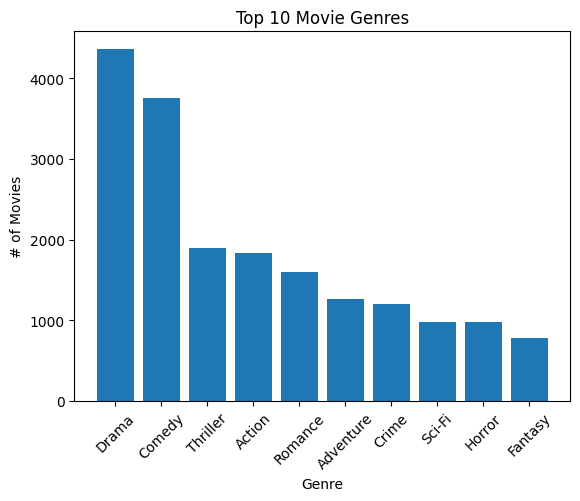

In [17]:
# Graph for the top 10 genres in dataset
genres = movies['genres'].str.split('|').explode()
totalCounts = genres.value_counts()

plt.bar(totalCounts.index[:10], totalCounts.values[:10])
plt.title('Top 10 Movie Genres')
plt.xlabel('Genre')
plt.ylabel('# of Movies')
plt.xticks(rotation=45)
plt.show()


In [6]:
#Store 'ratings' data in dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [7]:
#Create training and testing set
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [8]:
#Create SVD model
svdModel = SVD()
svdModel.fit(trainset)


In [9]:
# Predict on testing set using SVD model
pred = svdModel.test(testset)
print("MAE for Collaborative Filtering Method:", mae(pred))


MAE:  0.6745
MAE for Collaborative Filtering Method: 0.6745449711376771


In [10]:
# Create tfidf matrix
movies['combined'] = movies['genres']

tfidf = TfidfVectorizer(stop_words='english')
tfidfMatrix = tfidf.fit_transform(movies['combined'])


In [11]:
#Calculate cosine similarity for comparison
cosineMatrix = cosine_similarity(tfidfMatrix, tfidfMatrix)


In [12]:
#Clean the movies data by dropping duplicates
cleanDuplicates = pd.Series(movies.index, index=movies['clean_title']).drop_duplicates()


In [13]:
# Content Based recommendation method
def content_based(title, number=10):
    inputUser = clean_title(title)
    if inputUser not in cleanDuplicates:
        return []
    movie = cleanDuplicates[inputUser]

    scores = list(enumerate(cosineMatrix[movie]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    relatedMovies = scores[1:number+1] 
    listMovies = [i[0] for i in relatedMovies]

    return movies['title'].iloc[listMovies].tolist()


In [14]:
#Collaborative filtering recommendation method 
def collaborativeFiltering(uid, movieName, number=5):
    relatedMovies = content_based(movieName, number=20)
    returnMovies = []
    for title in relatedMovies:
        mid = movies[movies['title'] == title]['movieId'].values[0]
        pred = svdModel.predict(uid, mid)
        returnMovies.append((title, pred.est))
    returnMovies = sorted(returnMovies, key=lambda x: x[1], reverse=True)
    return [title for title, score in returnMovies[:number]]


In [15]:
uid = 1
inputUser = input("Type a movie name to generate a list of recommendations. Please spell and capitalize correctly!: ")
movie = clean_title(inputUser)


if movie not in cleanDuplicates:
    print(f"Sorry! Unable to find '{inputUser}'! Please Try Again.")
else:
    print(f"\nMovies similar to '{inputUser}':")
    recs = content_based(inputUser)
    for movie in recs:
        print(f"- {movie}")

    print(f"\nTop picks for you based on '{inputUser}':")
    recs2 = collaborativeFiltering(uid, inputUser,5)
    for movie in recs2:
        print(f"- {movie}")


Type a movie name to generate a list of recommendations. Please spell and capitalize correctly!:  Toy Story



Movies similar to 'Toy Story':
- Antz (1998)
- Toy Story 2 (1999)
- Adventures of Rocky and Bullwinkle, The (2000)
- Emperor's New Groove, The (2000)
- Monsters, Inc. (2001)
- Wild, The (2006)
- Shrek the Third (2007)
- Tale of Despereaux, The (2008)
- Asterix and the Vikings (Astérix et les Vikings) (2006)
- Turbo (2013)

Top picks for you based on 'Toy Story':
- Monsters, Inc. (2001)
- Toy Story 2 (1999)
- Moana (2016)
- Black Cauldron, The (1985)
- Inside Out (2015)


In [ ]:
uid = 1
inputUser = input("Type a Movie name for similarity heatmap: ")
movie = clean_title(inputUser)

if movie not in cleanDuplicates:
    print(f"Sorry! Unable to find '{inputUser}'! Please Try Again.")
else:
    uid2 = cleanDuplicates[movie]

    N = 20
    listOfMovies = list(range(len(movies)))
    listOfMovies.remove(uid2)
    randomMovies = random.sample(listOfMovies, N)

    scores = cosineMatrix[uid2, randomMovies]

    ranMovies = movies['title'].iloc[randomMovies].tolist()

    plt.figure(figsize=(15, 4))
    
    sns.heatmap([scores], xticklabels=ranMovies, yticklabels=[inputUser],
                cmap='coolwarm', annot=True, fmt=".2f", cbar=True)

    plt.title(f"Similarity: '{inputUser}' vs 20 Random Movies in Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
